In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
import time
import copy
import os
from torchsummary import summary

use_cuda = torch.cuda.is_available()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/DS5220_Project"

Mushroom_Dataset  Mushroom_Dataset_v2


In [ ]:
test_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [ ]:
batch_size = 64

val_dir = '/content/drive/My Drive/DS5220_Project/Mushroom_Dataset_v2/valid'
train_dir = '/content/drive/My Drive/DS5220_Project/Mushroom_Dataset_v2/train'
test_dir = '/content/drive/My Drive/DS5220_Project/Mushroom_Dataset_v2/test'

val_img_data = torchvision.datasets.ImageFolder(val_dir,transform=val_transforms,)
train_img_data = torchvision.datasets.ImageFolder(train_dir,transform=train_transforms,)
test_img_data = torchvision.datasets.ImageFolder(test_dir,transform=test_transforms,)

val_data_loader = torch.utils.data.DataLoader(val_img_data, batch_size=batch_size, shuffle=True)
train_data_loader = torch.utils.data.DataLoader(train_img_data, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_img_data, batch_size=batch_size, shuffle=True)

print(len(val_data_loader.dataset))
print(len(train_data_loader.dataset))
print(len(test_data_loader.dataset))


953
6684
1836


In [ ]:
class_names = test_img_data.classes
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Exidia', 'Hygrocybe', 'Inocybe', 'Lactarius', 'Pluteus', 'Russula', 'Suillus']


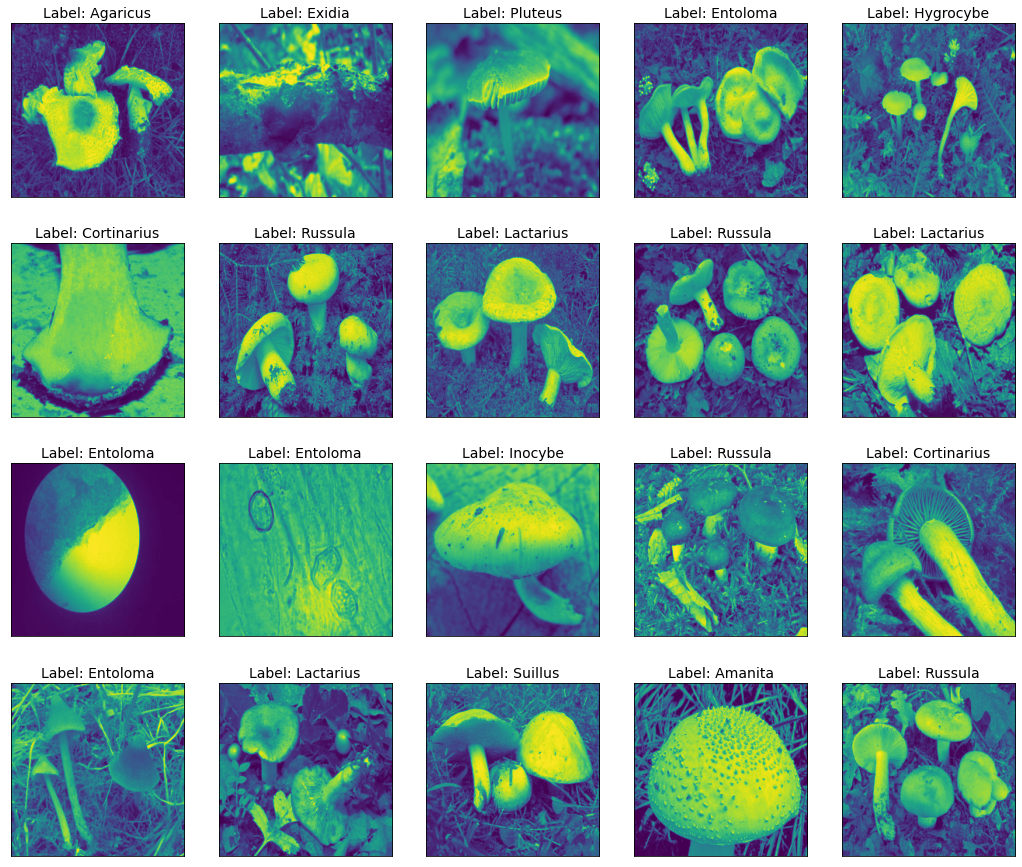

In [ ]:
class_name_key = [0,1,2,3,4,5,6,7,8,9,10,11]
cn = {class_name_key[i]: class_names[i] for i in range(len(class_name_key))}

images, labels = next(iter(train_data_loader))

fig = plt.figure(figsize=(18, 60))
for i in range(20):
    plt.subplot(15,5,i+1)
    plt.imshow(  images[i][0])
    plt.title(f'Label: {cn[labels[i].item()]}', fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
images, labels = next(iter(train_data_loader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)


images-size: torch.Size([64, 3, 224, 224])
out-size: torch.Size([3, 1810, 1810])


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device_net = models.resnet50(pretrained=True)
device_net = device_net.cuda() if device else device_net

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(device_net.parameters(), lr=0.001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = device_net.fc.in_features
device_net.fc = nn.Linear(num_ftrs, 12)
device_net.fc = device_net.fc.cuda() if use_cuda else device_net.fc
summary(device_net,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
n_epochs = 50
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_data_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_data_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = device_net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        device_net.eval()
        for data_t, target_t in (test_data_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = device_net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_data_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(device_net.state_dict(), 'resnetv.pt')
            print('Improvement-Detected, save-model')
    device_net.train()

Epoch 1

Epoch [1/50], Step [0/105], Loss: 2.5936
Epoch [1/50], Step [20/105], Loss: 2.4591
Epoch [1/50], Step [40/105], Loss: 2.4049
Epoch [1/50], Step [60/105], Loss: 2.3219
Epoch [1/50], Step [80/105], Loss: 2.1136
Epoch [1/50], Step [100/105], Loss: 1.9830

train-loss: 2.2903, train-acc: 23.4141
validation loss: 1.9178, validation acc: 47.5490

Improvement-Detected, save-model
Epoch 2

Epoch [2/50], Step [0/105], Loss: 1.8783
Epoch [2/50], Step [20/105], Loss: 1.8655
Epoch [2/50], Step [40/105], Loss: 1.7841
Epoch [2/50], Step [60/105], Loss: 1.5849
Epoch [2/50], Step [80/105], Loss: 1.2435
Epoch [2/50], Step [100/105], Loss: 1.1675

train-loss: 1.9308, train-acc: 60.8318
validation loss: 1.6125, validation acc: 63.3442

Improvement-Detected, save-model
Epoch 3

Epoch [3/50], Step [0/105], Loss: 1.1351
Epoch [3/50], Step [20/105], Loss: 1.0839
Epoch [3/50], Step [40/105], Loss: 1.0119
Epoch [3/50], Step [60/105], Loss: 1.1845
Epoch [3/50], Step [80/105], Loss: 1.0317
Epoch [3/50], 

In [ ]:
from google.colab import files
files.download('resnetv4.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

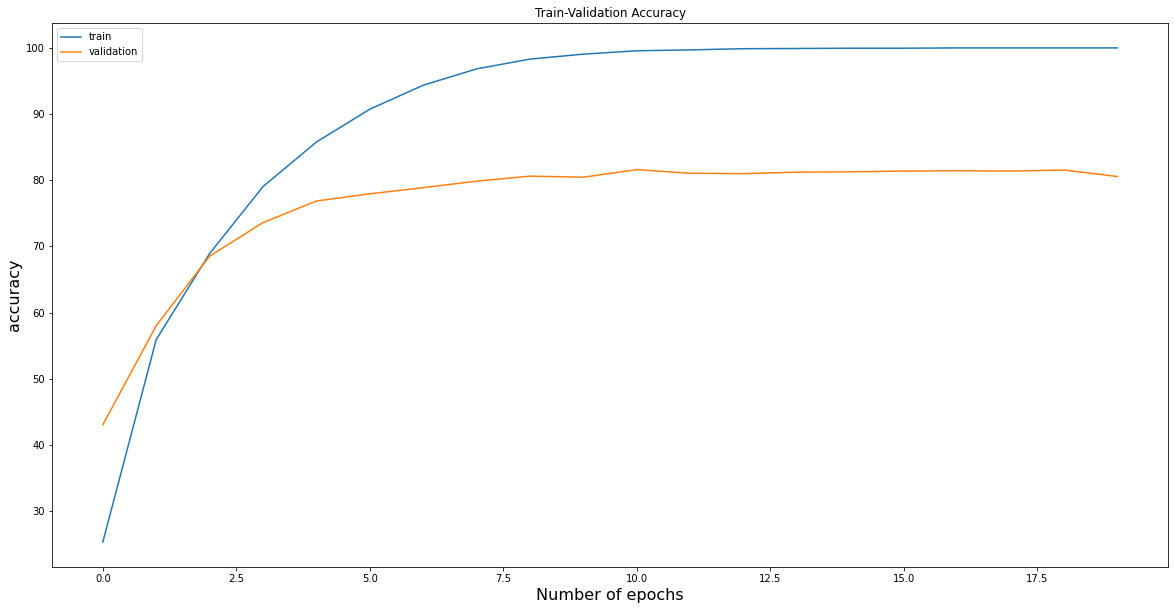

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.legend(loc='best')

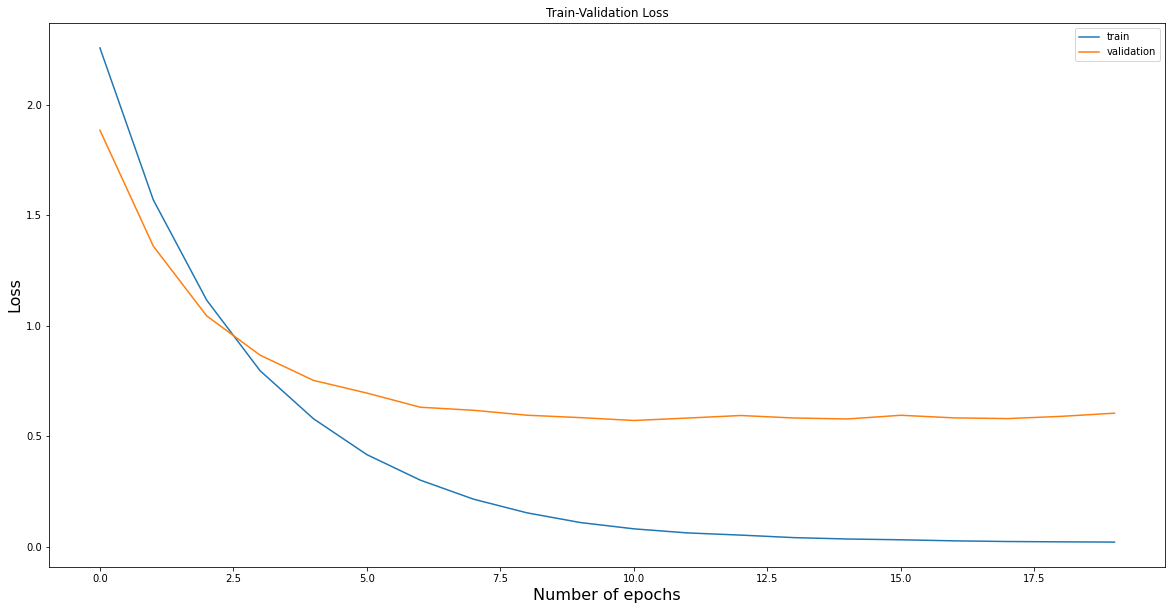

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('Number of epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='best')

In [ ]:
device_net.load_state_dict(torch.load('resnetv4.pt'))

<All keys matched successfully>

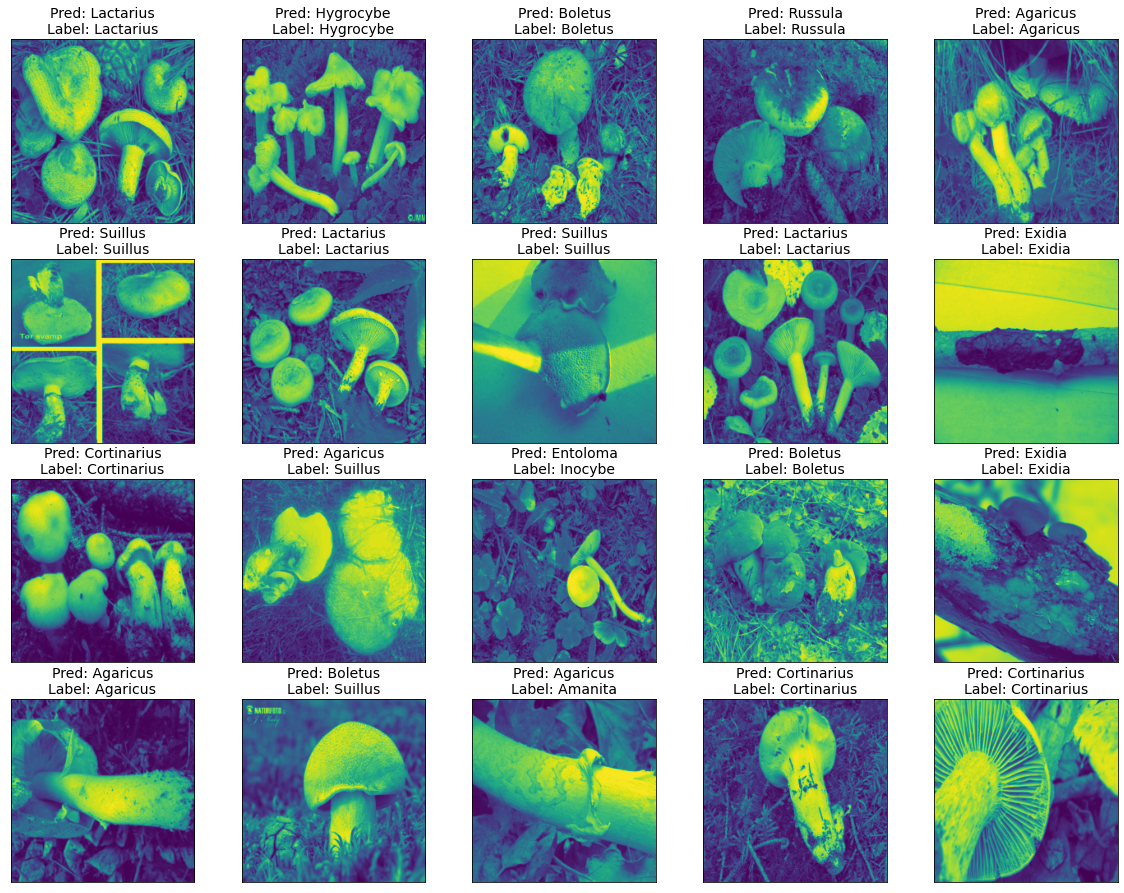

In [ ]:
images, labels = next(iter(test_data_loader))
inputs, labels = images.cuda(), labels.cuda()

output = device_net(inputs)
pred = output.argmax(dim=1)
inputs = inputs.cpu().numpy()
preds = pred.cpu().numpy() if use_cuda else pred.numpy()

fig = plt.figure(figsize=(20, 60))
_, predicted = torch.max(output, 1)

for i in range(20):
    plt.subplot(15,5,i+1)
    plt.imshow(inputs[i][0])
    plt.title(f'Pred: {cn[predicted[i].item()]}\nLabel: {cn[labels[i].item()]}', fontsize=14)
    plt.xticks([])
    plt.yticks([])

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7f91563a44f0 to Device at 0x7f9118f39430>